In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart
from bin.utils.tools import pretty_print

2025-04-30 22:26:03,934 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-30 22:26:03,934 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-30 22:26:03,936 - INFO - PriceDB Initialized successfully at 2025-04-30 22:26:03.936816
2025-04-30 22:26:03,936 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-30 22:26:03.936816
2025-04-30 22:26:03,937 - INFO - Established 3 database connections
2025-04-30 22:26:03,937 - bin.price.db_connect - INFO - Established 3 database connections
2025-04-30 22:26:04,006 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


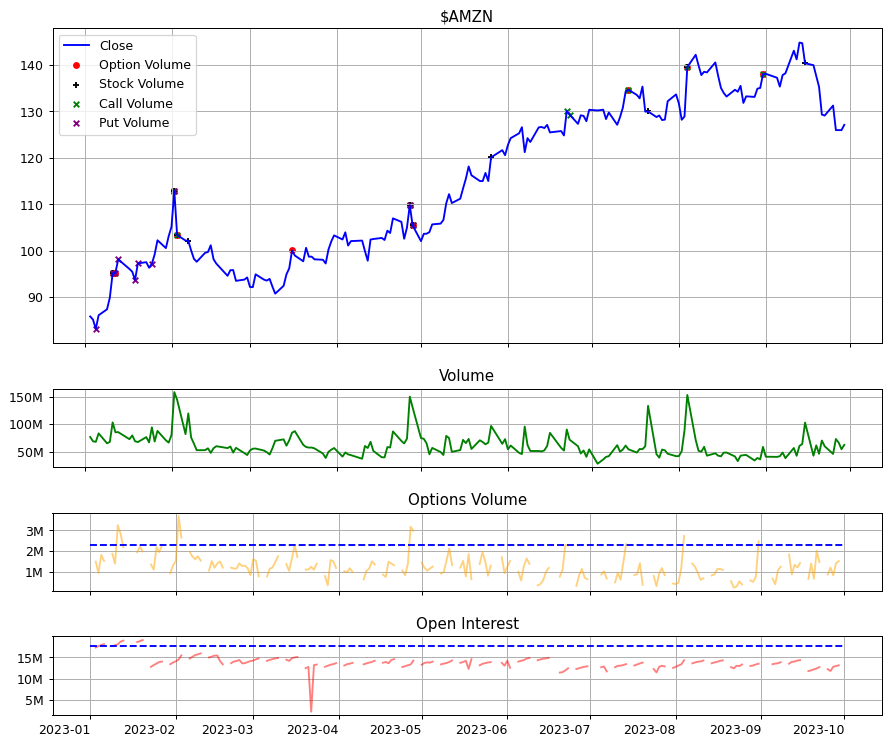

In [9]:
def get_aligned(stock, start_date = None, end_date = None):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.copy().sort_index()
    d = m.Optionsdb.get_daily_option_stats(stock).sort_index()
    d = d.resample('1D').sum()
    price_df = price_df.loc[d.index[0]:]
    
    if start_date is not None:
        price_df = price_df.loc[start_date:]
        d = d.loc[start_date:]
    if end_date is not None:
        price_df = price_df.loc[:end_date]
        d = d.loc[:end_date]

    d = d.replace(0, np.nan)    
    return price_df, d

def show_volume_oi(stock, start_date = None, end_date = None):
    pdf, odf = get_aligned(stock, start_date, end_date)
    pdf.columns = [x.lower() for x in pdf.columns]
    fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
    price_volume_oi_chart(odf, pdf, fig, ax, stock = stock)
    fig.show()
    return pdf, odf

_, _ = show_volume_oi('amzn', '2023-01-01', '2023-10-01')

In [11]:
from trend_results import TResults
tr = TResults(
    connections = '../../../',
    lookback_days= 90,
    window_size = 200, 
    period = 30
    
    )


2025-04-30 22:27:32,835 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-30 22:27:32,835 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-04-30 22:27:32,839 - INFO - PriceDB Initialized successfully at 2025-04-30 22:27:32.839309
2025-04-30 22:27:32,839 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-04-30 22:27:32.839309
2025-04-30 22:27:32,839 - INFO - Established 3 database connections
2025-04-30 22:27:32,839 - bin.price.db_connect - INFO - Established 3 database connections


2025-04-30 22:27:32,998 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [12]:
results = tr.analyze_stocks()

Processing gdx:   0%|          | 0/184 [00:00<?, ?it/s]  

Processing nvo: 100%|██████████| 184/184 [00:43<00:00,  4.25it/s, Success=1]


In [13]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
2,gdx,options_volume,up,normal,-0.000930,0.0,True
6,gdx,put_oi,up,low,-0.000835,0.0,True
7,gdx,call_volume,up,normal,-0.001084,0.0,True
8,gdx,put_volume,up,normal,-0.000711,1.0,True
11,gme,options_volume,up,normal,-0.000410,1.0,True
...,...,...,...,...,...,...,...
1573,tost,call_volume,down,normal,0.020492,0.0,True
1574,tost,put_volume,down,normal,0.001451,0.0,True
1577,pct,options_volume,down,normal,0.090091,1.0,True
1582,pct,call_volume,down,normal,0.093507,1.0,True


In [14]:
df.metric.unique()

array(['close_prices', 'stock_volume', 'options_volume', 'oi', 'atm_iv',
       'call_oi', 'put_oi', 'call_volume', 'put_volume'], dtype=object)

In [15]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_oi = df[(df.metric == 'call_oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_volume = df[(df.metric == 'call_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'down')].stock.tolist()
print("Increasing Options Volume:", increasing_options_volume)
print("Increasing Call OI:", increasing_call_oi)
print("Increasing Call Volume:", increasing_call_volume)
print("Increasing Price:", increasing_price)



Increasing Options Volume: ['gdx', 'gme', 'xlf', 'pfe', 'aal', 'igv', 'uwmc', 'smh', 'shy', 'enph', 'jks', 'slv', 'abbv', 'moo', 'rkt', 'nflx', 'pbw', 'ief', 'sono', 'xly', 'xlp', 'xlb', 'xlre', 'ibb', 'jets', 'tlt', 'ba', 'ge', 'xrt', 'aa', 'cvs', 'icln', 'fang', 'tsn', 'lulu', 'itb', 'tbt', 'gld', 'weat', 'x', 'tan', 'eog', 'tmv', 'spot', 'kre', 'djt', 'fxy', 'dltr', 'btu']
Increasing Call OI: ['gme', 'amzn', 'spy', 'aapl', 'aal', 'dkng', 'mdb', 'cvx', 'smh', 'mu', 'shy', 'bno', 'qcom', 'sol', 'mos', 'tgt', 'meta', 'abbv', 'moo', 'rkt', 'qqq', 'nflx', 'pbw', 'ief', 'sono', 'xly', 'xlp', 'xle', 'xlb', 'xlre', 'bito', 'clsk', 'jets', 'xlc', 'hsbc', 'kr', 'afrm', 'ba', 'ge', 'xrt', 'aa', 'icln', 'ctra', 'run', 'tsn', 'iwm', 'lulu', 'itb', 'tbt', 'c', 'gld', 'weat', 'v', 'x', 'eog', 'clx', 'jpm', 'tmv', 'sony', 'hood', 'pgr', 'afl', 'aig', 'kre', 'sofi', 'mpw', 'arm', 'ttd', 'amat', 'tdoc', 'rddt', 'dell', 'fxy', 'dltr', 'orcl', 'u', 'pct', 'btu']
Increasing Call Volume: ['gdx', 'gme', '

In [16]:
b = set(increasing_options_volume) & set(increasing_price) & set(increasing_call_volume) & set(increasing_call_oi)
print(b)

{'ief', 'tbt', 'icln', 'dltr', 'tsn', 'rkt', 'tmv', 'gld', 'fxy', 'shy', 'x'}


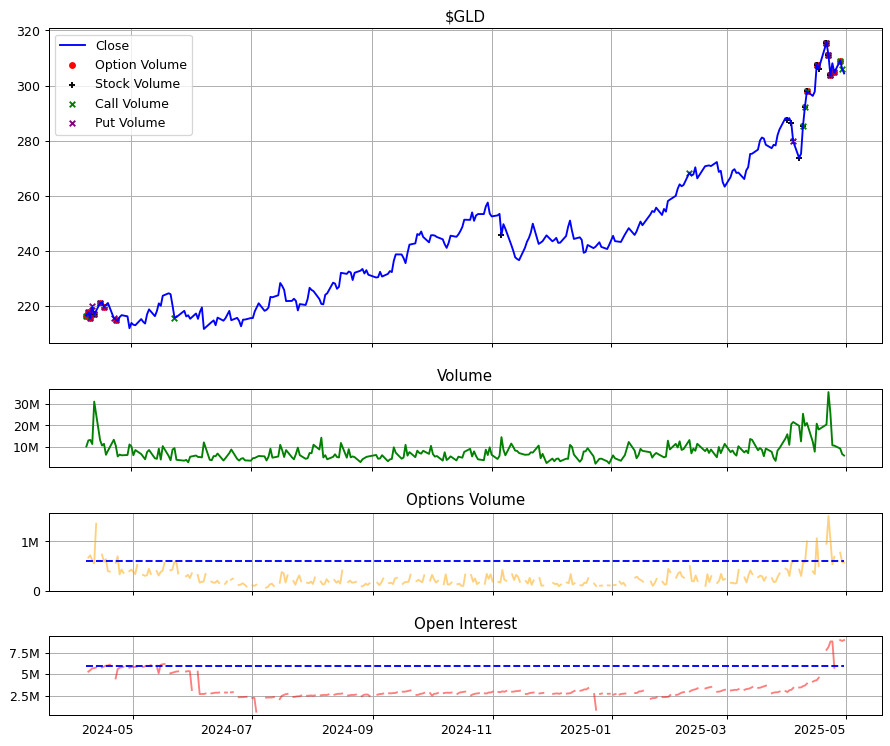

In [19]:
_, _ = show_volume_oi('gld','2024-04-07')

In [49]:

pretty_print(odf[['total_vol', 'call_vol_chng', 'put_vol_chng', 'total_oi', 'call_oi_chng', 'put_oi_chng']])

,total_vol,call_vol_chng,put_vol_chng,total_oi,call_oi_chng,put_oi_chng
date,,,,,,
2025-01-01,nan,nan,nan,nan,nan,nan
2025-01-02,"838,613.00","302,851.00","260,137.00","7,961,776.00","65,240.00","48,784.00"
2025-01-03,"605,963.00","-118,282.00","-114,368.00","8,238,743.00","224,645.00","52,322.00"
2025-01-04,nan,nan,nan,nan,nan,nan
2025-01-05,"1,702,785.00","880,119.00","535,437.00","7,411,441.00","24,413.00","45,629.00"
...,...,...,...,...,...,...
2025-04-26,nan,nan,nan,nan,nan,nan
2025-04-27,nan,nan,nan,nan,nan,nan
2025-04-28,"3,741,409.00","-3,442,220.00","-2,995,831.00","16,760,290.00","1,406,826.00","965,238.00"


In [ ]:
df[df.stock == stock]

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
1134,gld,close_prices,up,normal,0.002726,1.0,False
1135,gld,stock_volume,up,low,0.026925,1.0,False
1136,gld,options_volume,up,high,-0.000874,1.0,True
1137,gld,oi,up,normal,-0.000777,0.0,True
1138,gld,atm_iv,up,normal,-0.000232,1.0,True
1139,gld,call_oi,up,normal,-0.000920,0.0,True
1140,gld,put_oi,up,normal,-0.000596,0.0,True
1141,gld,call_volume,up,high,-0.000870,1.0,True
1142,gld,put_volume,up,normal,-0.000880,1.0,True


In [ ]:
result['S_T'].quantile(.95)

0.0

In [ ]:

change_df = df[df.change_point == 1]



In [ ]:
change_df[change_df.metric.isin(['call_oi','put_oi'])].stock.unique()

array(['gme', 'pfe', 'igv', 'pep', 'uwmc', 'mu', 'moo', 'ccj', 'ief',
       'xlb', 'ibb', 'wba', 'xrt', 'run', 'itb', 'sony', 'hood', 'pho',
       'ttd', 'smci', 'hims', 'rddt', 'fxy', 'dltr', 'adbe', 'orcl', 'u',
       'tost', 'pct', 'oklo', 'tem', 'btu'], dtype=object)

In [ ]:
change_df[change_df.stock == 'gme']

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
9,gme,close_prices,down,high,-0.003079,1.0,False
11,gme,options_volume,up,normal,-0.000411,1.0,True
13,gme,atm_iv,up,normal,0.000178,1.0,False
14,gme,call_oi,up,normal,-0.001240,1.0,True
16,gme,call_volume,up,normal,-0.000377,1.0,True


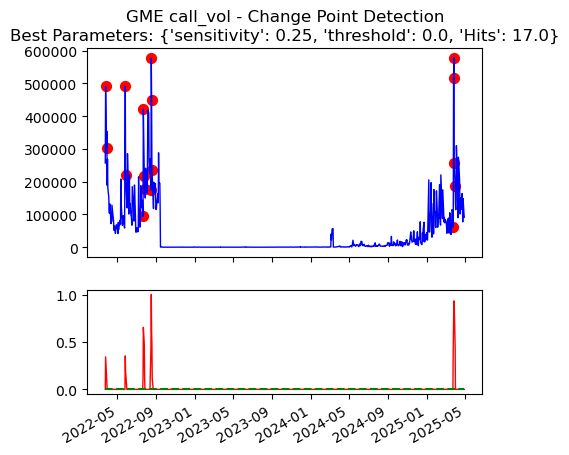

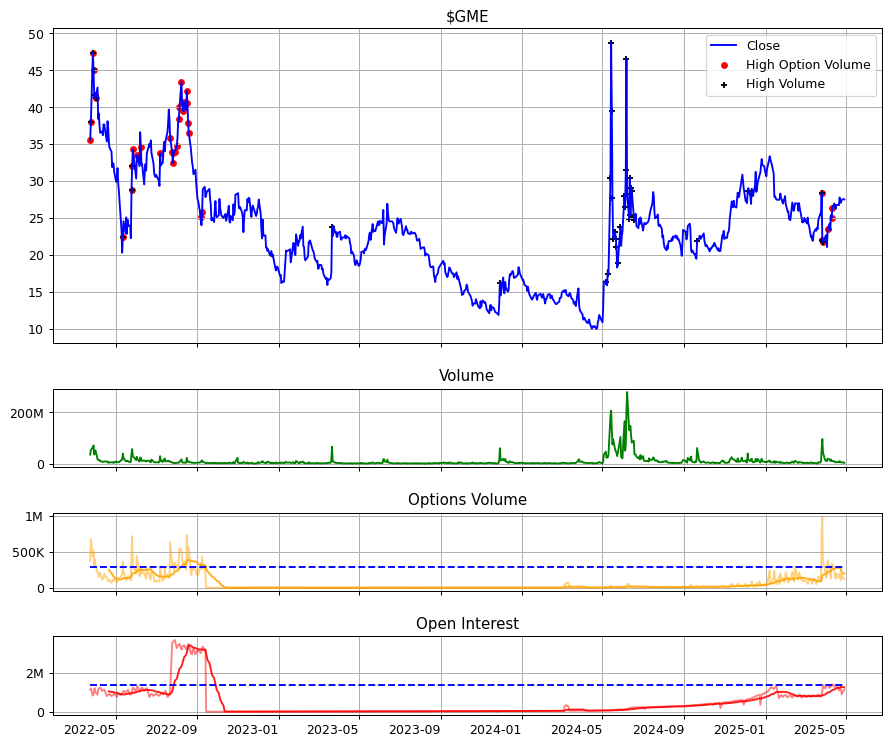

In [ ]:
stock = 'gme'; column = 'call_vol'
pdf, odf, result = plot_model(stock, column)
pdf.columns = [x.lower() for x in pdf.columns]
fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
price_volume_oi_chart(odf, pdf, fig, ax, stock = stock)
fig.show()